Importing needed libraries

In [30]:
# importing libraries
from display import print_board
import random
import chess
from evaluate import golden_evaluation as eval
import rich
from pprint import pprint
import math
import numpy as np
from opening import Polyglot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

# Monte Calso Tree Search

Here i am going to define the class Node for the Monte Calso Tree Search.

In [58]:

CHECKMATE_SCORE = 2
DEPTH = 5
LOSS_VALUE = 10
TOP_TIMES = 10
EXPLORATION = 1000
DEPTH_CHECKMATE_VALUE = 10

book = Polyglot(f'/Users/danila/Documents/Chess_C++/polyglot-collection/Book.bin')

def update_function(a, b):
    return a + b

class Node:
    def __init__(self, board):
        self.board = board
        self.status = 0
        self.wins = 0
        self.visited = 0
        self.ucb = 0
        self.children = {}

    def expand(self):
        legal = self.board.legal_moves
        for move in legal:
            new_board = self.board.copy()
            new_board.push(move)
            self.children[str(move)] = Node(new_board)
    
    def simulate(self, depth):
        self.status += 1
        if self.board.is_stalemate():
            return 0
        if self.board.is_checkmate():
            return - (1 / (depth * DEPTH_CHECKMATE_VALUE)) * CHECKMATE_SCORE
        if depth == DEPTH:
            evaluation = eval(self.board)
            if evaluation < 0:
                return evaluation / 24000 * LOSS_VALUE
            return (eval(self.board)) / 24000
        
        random_move = random.choice(list(self.board.legal_moves))
        new_board = self.board.copy()
        new_board.push(random_move)

        if str(random_move) in self.children:
            new_node = self.children[str(random_move)]
        else:
            new_node = Node(new_board)
            self.children[str(random_move)] = new_node

        new_node.visited += 1
        
        score = -new_node.simulate(depth + 1)

        new_node.wins = update_function(new_node.wins, score)

        return new_node.wins
    
    def explore(self, number):
        for i in range(number):
            self.simulate(1)
    
    def UCB(self, C=1.4):
        for move in self.children:
            try:
                #self.children[move].ucb = self.children[move].wins + \
                #                C * math.sqrt(math.log(self.status) / self.children[move].status)
                self.children[move].ucb = self.children[move].wins * self.children[move].status
            except:
                self.children[move].ucb = 0
        
    def selection(self):
        if len(self.children) == 0:
            # expantion section
            self.expand()
            self.explore(EXPLORATION)
            self.UCB()
            return

        max_ucb = -1e9
        move = None
        for child_key in self.children:
            child = self.children[child_key]
            ucb = child.ucb
            if ucb > max_ucb:
                max_ucb = ucb
                move = child_key
        self.children[move].selection()
        self.UCB()
        return
    
    def get_best(self, opening=True):
        if opening == True:
            opening_move = book.get(self.board)
            if opening_move is not None:
                return opening_move, None

        for i in range(TOP_TIMES):
            self.selection()
        
        max_ucb = -1e9
        move = None
        for child_key in self.children:
            child = self.children[child_key]
            ucb = child.ucb
            if ucb > max_ucb:
                max_ucb = ucb
                move = child_key
        return chess.Move.from_uci(move), max_ucb

    def output(self):
        for move in self.children:
            print(f'move = {move}, wins = {self.children[move].wins}, visited = {self.children[move].visited}, ucb = {self.children[move].ucb}')


  +------------------------+
8 |♚  ♝  ♔  .  .  .  .  . |
7 |♟  ♟  .  .  .  .  .  . |
6 |.  ♙  .  .  .  .  .  . |
5 |.  .  .  .  .  .  .  . |
4 |.  .  .  .  .  .  .  . |
3 |.  .  .  .  .  .  .  . |
2 |.  .  .  .  .  .  .  . |
1 |♖  .  .  .  .  .  .  . |
  +------------------------+
    a  b  c  d  e  f  g  h
(Move.from_uci('c8d8'), 161.37333333333328)
[161.37333333333328, 26.371041666666667, -10, -10, 57.40066666666666, -10, -1.7810833333333287, -10, 43.68745833333333, -10, -10, 58.07504166666664, -10, -10, 1.1431250000000004, 94.50562500000002]


/var/folders/nt/68fj9nz502sckw64jyxgg3ww0000gn/T/ipykernel_71951/328966320.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
/var/folders/nt/68fj9nz502sckw64jyxgg3ww0000gn/T/ipykernel_71951/328966320.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
/var/folders/nt/68fj9nz502sckw64jyxgg3ww0000gn/T/ipykernel_71951/328966320.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated sinc

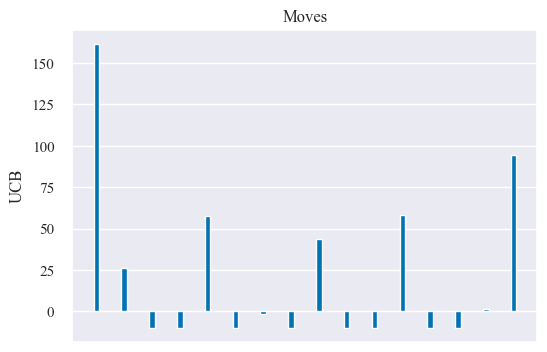

In [61]:
board = chess.Board("kbK5/pp6/1P6/8/8/8/8/R7 w - - 0 1")
print_board(board)
node = Node(board)

print(node.get_best())
move, score = node.get_best()

ucb = []
for child_key in node.children:
    child = node.children[child_key]
    ucb.append(max(-10, child.ucb))

print(ucb)

# Set styles
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.style.use(['seaborn'])
sns.set(palette='colorblind')
matplotlib.rc("font", family="Times New Roman", size=12)

labels = [f'n={i}' for i in range(len(ucb))]
a = list(ucb)
bar_width = 0.20

colors = sns.color_palette(palette='colorblind')
columns = ('n=1', 'n=2', 'n=3', 'n=4', 'n=5')

index = np.arange(len(labels))
fig = plt.figure(figsize=(6,4))
plt.bar(index, a, bar_width)

fig.subplots_adjust(bottom=0.1)

plt.ylabel('UCB')
plt.xticks([])
plt.title('Moves')
plt.show()
